# Prelude

In [1]:
import copy
import pickle
import random
import warnings
from pathlib import Path
from types import SimpleNamespace

import botorch
import gpytorch
import numpy as np
import torch
from sklearn_extra.cluster import KMedoids

import lib.priors
from extras import kernel_maker, train_gp, multi_start_train, initialize_model, assign_priors, assign_parameter_dists
from lib.acquisitions import MAXIQR


def cantor_pairing(x, y):
    return (((x + y) * (x + y + 1)) // 2 + y) % 2147483647


def reset_seed(seed, i):
    pair_seed = cantor_pairing(seed, i)
    torch.manual_seed(pair_seed)
    random.seed(pair_seed)
    np.random.seed(pair_seed)
    return pair_seed


def kmedoids(x, n_clusters, random_state, max_iter, **kwargs):
    km = KMedoids(n_clusters=n_clusters, random_state=random_state, max_iter=max_iter, **kwargs).fit(x)

    keep_index = np.zeros(x.shape[0], dtype=bool)
    keep_index[km.medoid_indices_] = True
    return keep_index

## Experiment parameters

In [2]:
result_folder = Path('./results/')
result_folder.mkdir(parents=True, exist_ok=True)

initial_seed = 0
n_chains = 2
sample_size = 1000
n_subposteriors = 3

From this point onwards, the each cell can be run independently

# Sample subposteriors

In [3]:
for i in range(n_subposteriors):
    random_seed = reset_seed(initial_seed, i)
    rng = np.random.default_rng(random_seed)
    n = 1000
    std = 0.75
    roots = [[-0.6, 0.6], [-0.6, 0.6]]
    observations = rng.normal(size=(n, 1), scale=std)

    sub_posterior = lib.distributions.PolynomialPosterior(
        observations,
        roots=roots, std=std, parallel_factor=1 / n_subposteriors
    )
    # subdists, sample_size, D+1
    subposterior_samples = sub_posterior.sample(sample_size=sample_size, seed=random_seed, chains=n_chains)
    d = subposterior_samples.shape[-1] - 1
    samples_min = subposterior_samples[..., :d].min(axis=0)
    samples_max = subposterior_samples[..., :d].max(axis=0)
    bounds = np.array([
        samples_min * np.where(samples_min > 0, 0.9, 1.1),
        samples_max * np.where(samples_max > 0, 1.1, 0.9)
    ])
    with open(result_folder / f'{i}_subposterior.pkl', 'wb') as f:
        pickle.dump(SimpleNamespace(
            d=d,
            samples=subposterior_samples,
            bounds=bounds,
            sub_posterior=sub_posterior,
        ), f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL PolynomialPosterior_ae3b682dcc0a47dd97ee94c04f408515 NOW.


# Fit initial GP

In [4]:
# Always use Cholesky
gpytorch.settings.fast_computations(covar_root_decomposition=False, log_prob=False, solves=False).__enter__()

In [5]:
for i in range(n_subposteriors):
    random_seed = reset_seed(initial_seed, i)

    namespace = pickle.loads((result_folder / f'{i}_subposterior.pkl').read_bytes())
    d, samples, bounds = namespace.d, namespace.samples, torch.from_numpy(namespace.bounds)
    del namespace

    # %% Create GP

    selected_idx = kmedoids(samples, n_clusters=20 * (d + 2), max_iter=1000, random_state=random_seed,
                            init='k-medoids++')
    gp = lib.gps.LogLikelihoodModel(
        torch.tensor(samples[selected_idx, :d]),
        torch.tensor(samples[selected_idx, d]),
        kernel_maker=kernel_maker(d)
    )

    gp.cpu()
    initialize_model(gp, bounds)
    assign_priors(gp, bounds)
    stage_1_results = multi_start_train(gp, num_starts=5, num_samples=50, gtol=1e-8)

    with open(result_folder / f'{i}_stage_1.pkl', 'wb') as f:
        pickle.dump(SimpleNamespace(
            results=stage_1_results,
            x=gp.train_inputs[0], y=gp.train_targets,
            bounds=bounds
        ), f)

    # %% Training set acquisition
    acq = MAXIQR(gp, 50)
    rounds = 25
    batch_size = d
    remaining_idx = torch.tensor(~selected_idx)

    batched_samples = torch.from_numpy(samples[:, :d]).view(-1, 1, d)
    stage_2_results = [None] * rounds
    for j in range(rounds):
        gp.eval()
        for _ in range(batch_size):
            samples_score = acq.forward(batched_samples[remaining_idx])
            best_idx = remaining_idx.nonzero().view(-1)[torch.argmax(samples_score)]
            remaining_idx[best_idx] = False
            acq.set_X_pending(batched_samples[[best_idx], 0, :])
        gp.set_train_data(
            inputs=torch.tensor(samples[~remaining_idx, :d]).view(-1, d),
            targets=torch.tensor(samples[~remaining_idx, d]),
            strict=False
        )
        acq.set_X_pending(None)
        try:
            assign_parameter_dists(gp, bounds)
            assign_priors(gp, bounds)
            stage_2_results[j] = multi_start_train(gp, num_starts=5, num_samples=50, gtol=1e-8, try_initial=True)
        except gpytorch.utils.errors.NotPSDError:
            #         stage_2_results[j] =  None
            raise RuntimeError(f'GP {i} has failed on stage 2, round {j}')

    (result_folder / f'{i}_stage_2.pkl').write_bytes(pickle.dumps(SimpleNamespace(
        results=stage_2_results[-1],
        x=gp.train_inputs[0], y=gp.train_targets,
        bounds=bounds,
        acq_results=stage_2_results
    )))

C:\Users\sentr\Programas\miniconda\envs\ebmcgp\lib\site-packages\ipykernel_launcher.py:41: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:882.)


# Sample sharing

In [6]:
for i in range(n_subposteriors):
    random_seed = reset_seed(initial_seed, i)

    past_results = [
        pickle.loads((result_folder / f'{i}_stage_2.pkl').read_bytes())
        for i in range(n_subposteriors)
    ]

    subposterior = pickle.loads((result_folder / f'{i}_subposterior.pkl').read_bytes()).sub_posterior

    my_past_result = past_results[i]
    d = my_past_result.x.shape[-1]

    samples_min = np.min([r.bounds[0].numpy() for r in past_results], axis=0)
    samples_max = np.max([r.bounds[1].numpy() for r in past_results], axis=0)

    numpy_bounds = np.array([
        samples_min * np.where(samples_min > 0, 0.9, 1.1),
        samples_max * np.where(samples_max > 0, 1.1, 0.9)
    ])

    gp = lib.gps.LogLikelihoodModel(my_past_result.x, my_past_result.y, kernel_maker=kernel_maker(d))

    gp.cpu()
    initialize_model(gp, torch.tensor(numpy_bounds))
    gp.load_state_dict(my_past_result.results[0].state_dict, strict=False)
    assign_priors(gp, torch.tensor(numpy_bounds))

    predictive_density_threshold = 0.01
    logpdf_threshold = my_past_result.y.max() - 20 * d

    selected_shared_samples = [None] * n_subposteriors
    selected_shared_samples[i] = torch.tensor([])
    for j in range(n_subposteriors):
        if i == j:
            continue

        samples_to_share = past_results[j].x
        f_actual = torch.from_numpy(subposterior.logpdf(samples_to_share.numpy())).to(gp.train_inputs[0])

        f_pred = gp.posterior(samples_to_share).mvn

        predictive_density = f_pred.to_data_independent_dist().log_prob(f_actual).exp()

        selection_criteria = (predictive_density < predictive_density_threshold)
        selection_criteria &= (f_pred.loc >= logpdf_threshold) | (f_actual >= logpdf_threshold)

        selected_shared_samples[j] = samples_to_share[selection_criteria]

    selected_shared_samples = torch.cat(selected_shared_samples, dim=0)

    if selected_shared_samples.shape[0] > 25 * d:
        selected_shared_samples = selected_shared_samples[
            kmedoids(selected_shared_samples.numpy(), 25 * d, max_iter=1000, random_state=random_seed,
                     init='k-medoids++')]

    # Add and train
    gp.set_train_data(
        inputs=torch.cat([gp.train_inputs[0], selected_shared_samples], dim=0).to(gp.train_inputs[0]),
        targets=torch.cat([gp.train_targets, torch.from_numpy(subposterior.logpdf(selected_shared_samples.numpy()))],
                          dim=0).to(gp.train_targets),
        strict=False
    )

    initialize_model(gp, torch.tensor(numpy_bounds))
    gp.load_state_dict(my_past_result.results[0].state_dict, strict=False)
    assign_priors(gp, torch.tensor(numpy_bounds))
    assign_parameter_dists(gp, torch.tensor(numpy_bounds))

    try:
        stage_3_results = multi_start_train(gp, num_starts=5, num_samples=50, gtol=1e-8, try_initial=True)
    except gpytorch.utils.errors.NotPSDError:
        stage_3_results = None
        raise RuntimeError(f'GP {i} has failed on stage 3')

    (result_folder / f'{i}_stage_3.pkl').write_bytes(pickle.dumps(SimpleNamespace(
        results=stage_3_results,
        x=gp.train_inputs[0], y=gp.train_targets,
        bounds=torch.tensor(numpy_bounds)
    )))

# Active sampling

In [7]:
for i in range(n_subposteriors):
    random_seed = reset_seed(initial_seed, i)

    my_past_result = pickle.loads((result_folder / f'{i}_stage_3.pkl').read_bytes())
    d = my_past_result.x.shape[-1]
    bounds = my_past_result.bounds

    gp = lib.gps.LogLikelihoodModel(my_past_result.x, my_past_result.y, kernel_maker=kernel_maker(d))
    subposterior = pickle.loads((result_folder / f'{i}_subposterior.pkl').read_bytes()).sub_posterior

    gp.cpu()
    initialize_model(gp, bounds)
    gp.load_state_dict(my_past_result.results[0].state_dict, strict=False)
    assign_priors(gp, bounds)

    past_state = copy.deepcopy(gp.state_dict())

    acquisition_num = 25
    batch_acquisition_size = d
    candidates_list = np.empty((acquisition_num, batch_acquisition_size, d + 1), dtype=float)

    acq = MAXIQR(gp, 50)
    acq.cpu()
    results = np.empty(acquisition_num, dtype=object)
    for j in range(acquisition_num):
        gp.eval()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            candidates, _ = botorch.optim.optimize.optimize_acqf(
                acq, bounds, q=batch_acquisition_size, num_restarts=15, raw_samples=256, sequential=True
            )
            with torch.no_grad():
                candidates_y = torch.from_numpy(subposterior.logpdf(candidates[..., :d].cpu().numpy())).to(candidates)
            candidates_list[j, :, :d] = candidates.reshape(-1, d)
            candidates_list[j, :, d] = candidates_y.numpy().reshape(-1)
            train_x = gp.train_inputs[0]
            train_y = gp.train_targets
            gp.set_train_data(
                inputs=torch.cat([train_x, candidates.to(train_x)], dim=0),
                targets=torch.cat([train_y, candidates_y.to(train_y)], dim=0),
                strict=False
            )
            gp.train()
            try:
                assign_priors(gp, bounds)
                if j < 5:
                    assign_parameter_dists(gp, bounds)
                    results[j] = multi_start_train(gp, num_starts=5, num_samples=10, gtol=1e-8, try_initial=True,
                                                   initial_maxiter=100)
                else:
                    results[j] = train_gp(gp, maxiter=100, gtol=1e-8)
            except gpytorch.utils.errors.NotPSDError:
                raise

    (result_folder / f'{i}_stage_4.pkl').write_bytes(pickle.dumps(SimpleNamespace(
        results=results[-1],
        x=gp.train_inputs[0], y=gp.train_targets,
        bounds=bounds,
        acq_results=results,
        past_state=past_state,
        candidates_list=candidates_list,
    )))

# Plotting

In [8]:
past_results = [
    pickle.loads((result_folder / f'{i}_stage_4.pkl').read_bytes())
    for i in range(n_subposteriors)
]
d = past_results[0].x.shape[-1]
bounds = past_results[0].bounds

gps = [
    lib.gps.LogLikelihoodModel(past_results[i].x, past_results[i].y, kernel_maker=kernel_maker(d))
    for i in range(n_subposteriors)
]

subposteriors = [
    pickle.loads((result_folder / f'{i}_subposterior.pkl').read_bytes()).sub_posterior
    for i in range(n_subposteriors)
]

for i, gp in enumerate(gps):
    gp.cpu()
    initialize_model(gp, bounds)
    gp.load_state_dict(past_results[i].results[0].state_dict, strict=False)
    assign_priors(gp, bounds)
    gp.eval()


def make_grid(bounds, lin_n):
    lin_x = np.linspace(bounds[0], bounds[1], num=lin_n)
    dx = lin_x[1] - lin_x[0]
    grid_x = np.stack(np.meshgrid(*(lin_x[:, i] for i in range(d)), indexing='ij'), axis=-1)

    return grid_x, dx, lin_x


plot_bounds = np.array([[-1, -1], [1, 1]])
n_lin = 500
grid_x, dx, lin_x = make_grid(plot_bounds, n_lin)


def combine_logpdfs(log_pdfs):
    start = next(log_pdfs)
    return sum(log_pdfs, start)


def eval_grid(grid_x, f, block_size=1_000):
    d = dx.shape[0]
    if block_size == 0:
        grid_y = f(grid_x.reshape(-1, d)).reshape(grid_x.shape[:2])
    else:
        grid_y = np.zeros(grid_x.shape[:-1])
        for i in range(0, np.prod(grid_x.shape[:-1]), block_size):
            f_input = grid_x.flat[i * d:(i + block_size) * d].view()
            f_input.shape = (-1, d)
            grid_y.flat[i:i + block_size] = f(f_input).reshape(-1)
    grid_y = grid_y - grid_y.max()
    return grid_y

In [9]:
with torch.no_grad():
    gp_logpdf = eval_grid(grid_x, lambda x: combine_logpdfs(gp(torch.from_numpy(x)) for gp in gps).loc)
true_logpdf = eval_grid(grid_x, lambda x: combine_logpdfs(p.logpdf(x) for p in subposteriors))

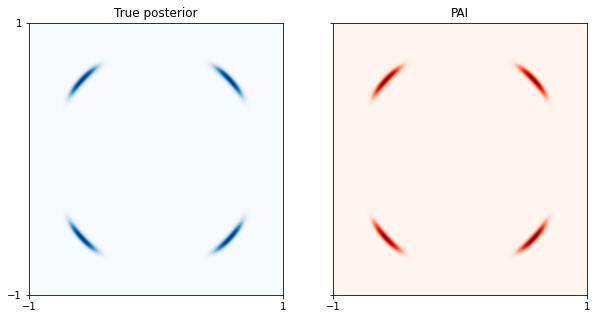

In [10]:
import matplotlib.pyplot as plt

f, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
axs[0].imshow(np.exp(true_logpdf.T), aspect='auto', extent=plot_bounds.T.reshape(-1), origin='lower', cmap='Blues')
axs[0].set_title('True posterior')
axs[1].imshow(np.exp(gp_logpdf.T), aspect='auto', extent=plot_bounds.T.reshape(-1), origin='lower', cmap='Reds')
axs[1].set_title('PAI')
axs[0].set_xticks(plot_bounds[:, 0]);
axs[0].set_yticks(plot_bounds[:, 1]);